**ADS 504 - Final Project**

Team #1: Lorena Dorado, Jose Padilla, Tysir Shehadey

[Link to colab:](https://colab.research.google.com/drive/1PsfJpbSpvKXoyf-guUt_6pjyC9GhM7_E?usp=sharing)

[https://colab.research.google.com/drive/1PsfJpbSpvKXoyf-guUt_6pjyC9GhM7_E?usp=sharing](https://colab.research.google.com/drive/1PsfJpbSpvKXoyf-guUt_6pjyC9GhM7_E?usp=sharing)

# Blood Cell Data

This project uses a dataset containing 17,092 images of normal blood cells from healthy individuals with no infection or disease.  It includes eight types of cells: neutrophils, eosinophils, basophils, lymphocytes, monocytes, immature granulocytes, erythroblasts, and platelets. The labels were annotated bt a licensed pathologist.

The team will build machine learning models that make predictions wether a blood cell is a particular type of cell.

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import zipfile
import requests
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from time import time
import sklearn
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib.image import imread
import glob
import cv2
from sklearn import cluster, decomposition
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers, models

In [ ]:
from tensorflow.keras import layers, models

tf.config.optimizer.set_jit(True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Loading the Data:**

Images from Kaggle are unzipped and uploaded to Google Drive. Connect to  Google Drive to access.

In [ ]:
# Load Data
# URL of the zip file
url = "https://www.renaqd.com/ADS/bloodcells_dataset.zip"
bloodcells_dataset = "bloodcells_dataset"
zip_file_path = "bloodcells_dataset.zip"

# Check if the bloodcells_dataset folder exists
if not os.path.exists(bloodcells_dataset):
    # Download the zip file
    response = requests.get(url)
    with open(zip_file_path, 'wb') as file:
        file.write(response.content)

    # Ensure the bloodcells_dataset folder exists
    os.makedirs(bloodcells_dataset, exist_ok=True)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(bloodcells_dataset)

    print(f"Extracted files to {bloodcells_dataset}")
else:
    print(f"The folder '{bloodcells_dataset}' already exists")

Extracted files to bloodcells_dataset


In [ ]:
path = "bloodcells_dataset"
print("\nRetrieving blood cell images from:")
print(path)

# Glob to search recursively within path
folders = glob.glob(os.path.join(path, '**'), recursive=True) #  finds all the pathnames matching a specified pattern
i = 0
cell_col = []

for folder in folders:
    for f in glob.glob(folder+'/*.jpg'):
        i = i +1
        cell_col.append(f)

img_count = str(i)
print("\nBlood bell images found: " + str(i))


Retrieving blood cell images from:
bloodcells_dataset

Blood bell images found: 17092


In [ ]:
# Save matrix
cell_col = np.array(cell_col)
np.save('cell_col.npy', cell_col)

# cell_col = np.load('cell_col.npy')

In [ ]:
# Dictionary to store one image path per folder
folder_image_dict = {}

# Loop through each folder and subfolder
for folder in folders:
    # Check if it is a directory
    if os.path.isdir(folder):

        # Find all .jpg files in the current folder
        jpg_files = glob.glob(os.path.join(folder, '*.jpg'))
        print(f"{len(jpg_files)} image files in {folder}")

        if jpg_files:
            # Store the first image found in the current folder
            folder_image_dict[folder] = jpg_files[0]

0 image files in bloodcells_dataset/
0 image files in bloodcells_dataset/bloodcells_dataset
3117 image files in bloodcells_dataset/bloodcells_dataset/eosinophil
2348 image files in bloodcells_dataset/bloodcells_dataset/platelet
3329 image files in bloodcells_dataset/bloodcells_dataset/neutrophil
1551 image files in bloodcells_dataset/bloodcells_dataset/erythroblast
1420 image files in bloodcells_dataset/bloodcells_dataset/monocyte
1218 image files in bloodcells_dataset/bloodcells_dataset/basophil
1214 image files in bloodcells_dataset/bloodcells_dataset/lymphocyte
2895 image files in bloodcells_dataset/bloodcells_dataset/ig


# EDA and Pre-Processing

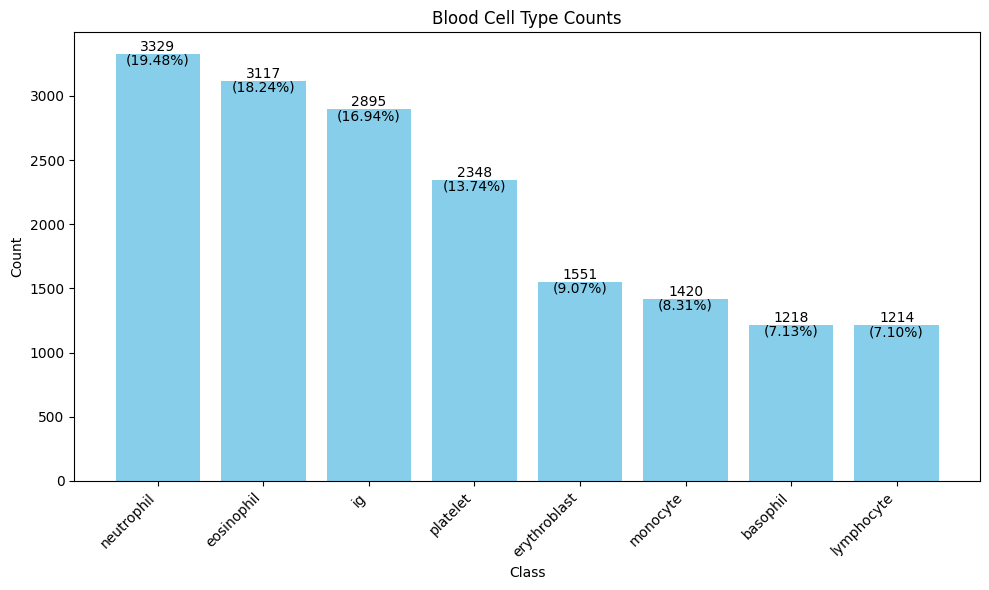

In [ ]:
# Classes
classes = ["platelet", "monocyte", "erythroblast", "lymphocyte", "eosinophil",
           "basophil", "ig", "neutrophil"]
frequencies = [2348, 1420, 1551, 1214, 3117, 1218, 2895, 3329]

# Sort the classes by count
sorted_data = sorted(zip(classes, frequencies), key=lambda x: x[1], reverse=True)
sorted_classes, sorted_frequencies = zip(*sorted_data)

# Sum of frequencies for ratio
total_count = sum(sorted_frequencies)

# Calculate the ratio of each class
class_ratios = [freq / total_count for freq in sorted_frequencies]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_classes, sorted_frequencies, color='skyblue', label="Count")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Blood Cell Type Counts")
plt.xticks(rotation=45, ha='right')

# Count values above the bars
for i, freq in enumerate(sorted_frequencies):
    plt.text(i, freq, str(freq), ha='center', va='bottom')

# Ratio values on top
for i, ratio in enumerate(class_ratios):
    plt.text(i, sorted_frequencies[i], f"({ratio:.2%})", ha='center', va='top', color='black')

plt.tight_layout()
plt.show()

In [ ]:
def plot_images_from_folders(folder_image_dict, convert_to_rgb=False, convert_to_gray=False):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
    axes = axes.flatten()

    for i, (folder, img_path) in enumerate(folder_image_dict.items()):
        if i >= 8:  # Plot 8 images
            break

        img = cv2.imread(img_path)  # Load the image from the specified file

        if convert_to_gray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale if True
            axes[i].imshow(img, cmap='gray')  # Display the image in grayscale
        elif convert_to_rgb:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB if True
            axes[i].imshow(img)  # Display the image in RGB
        else:
            axes[i].imshow(img)  # Display the original image

        axes[i].set_title(os.path.basename(folder))  # Set the title as the folder name
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Displaying 1 image from each type of blood cell.

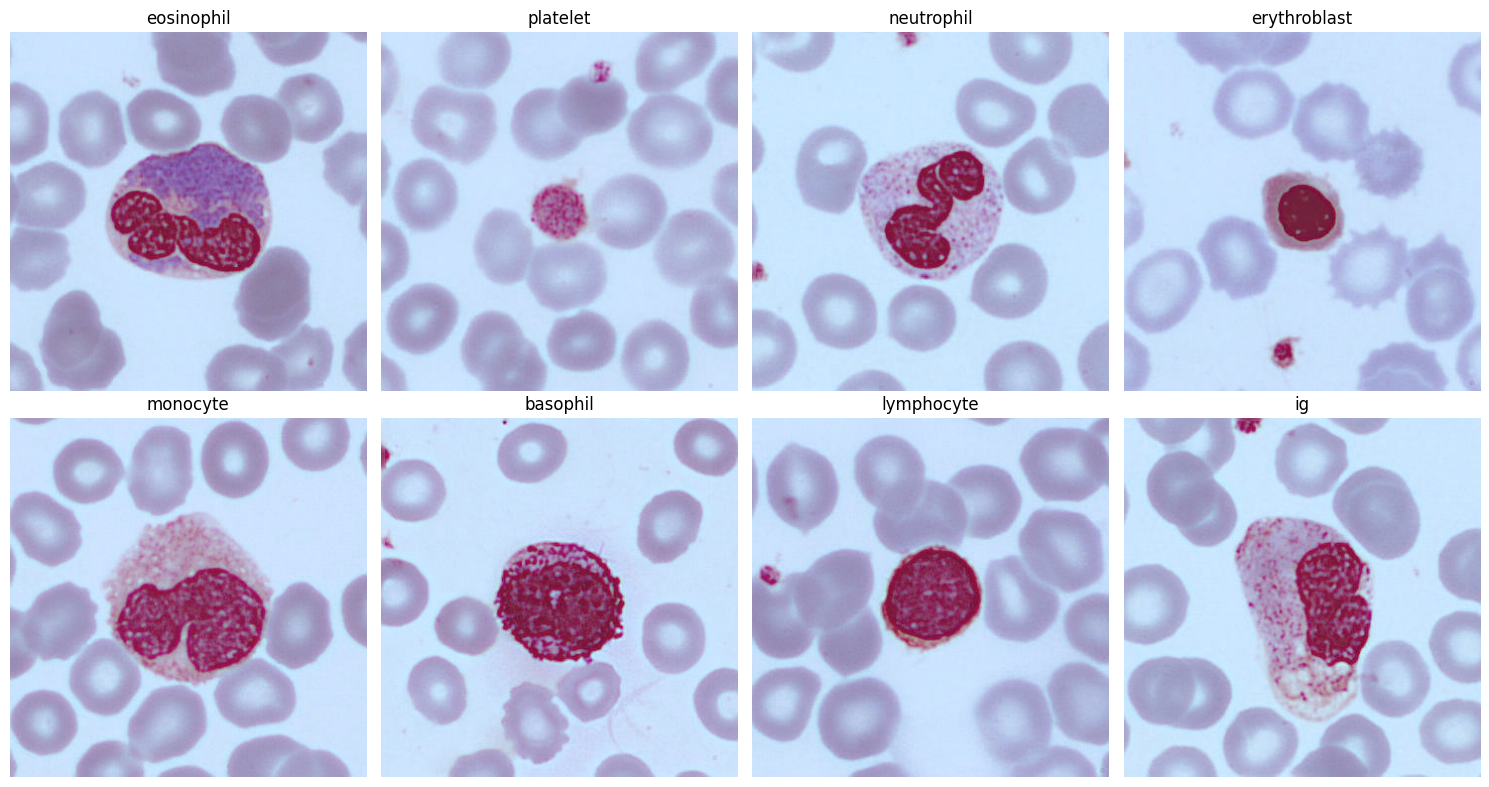

In [ ]:
plot_images_from_folders(folder_image_dict)

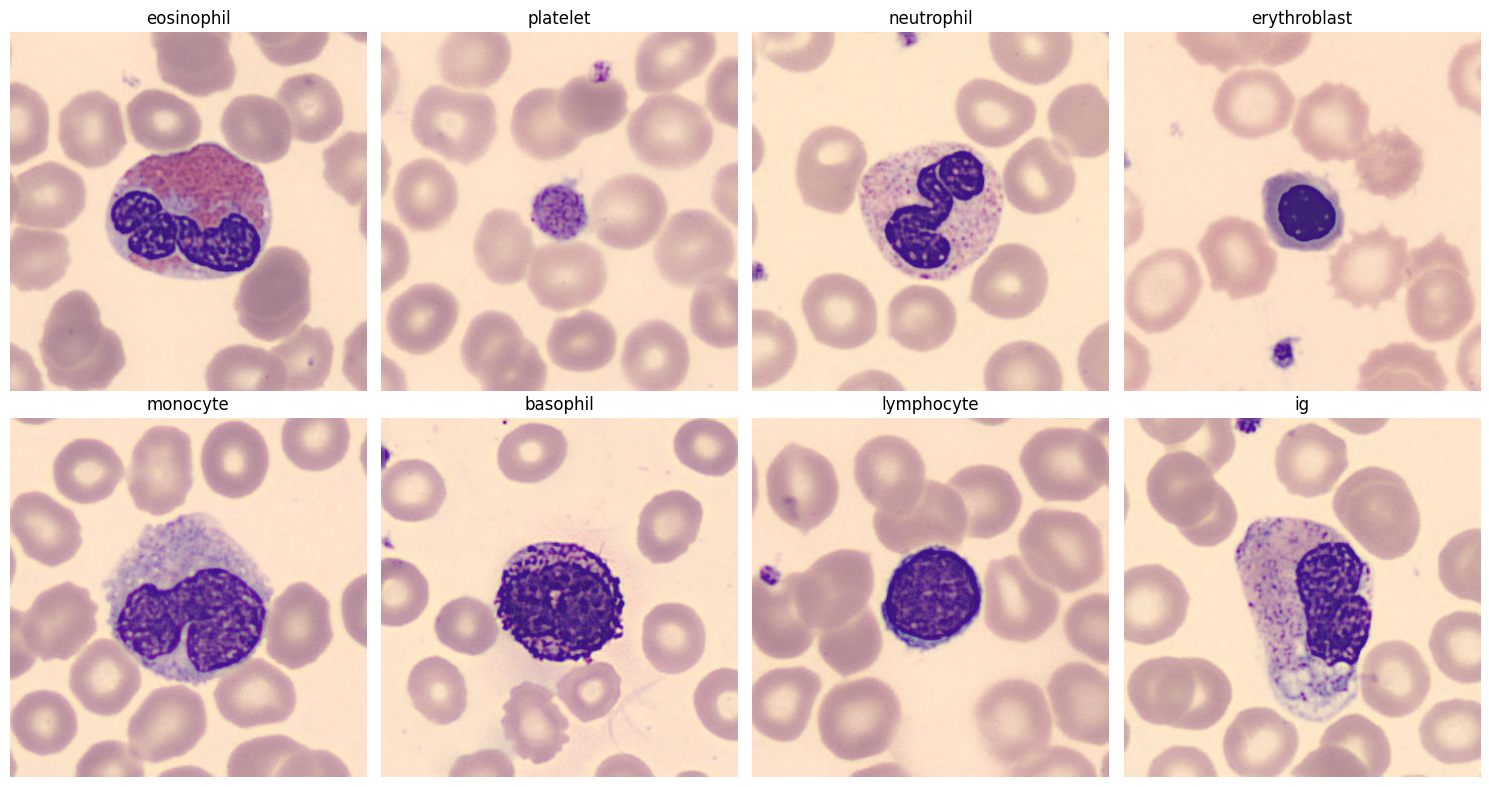

In [ ]:
plot_images_from_folders(folder_image_dict, convert_to_rgb=True)

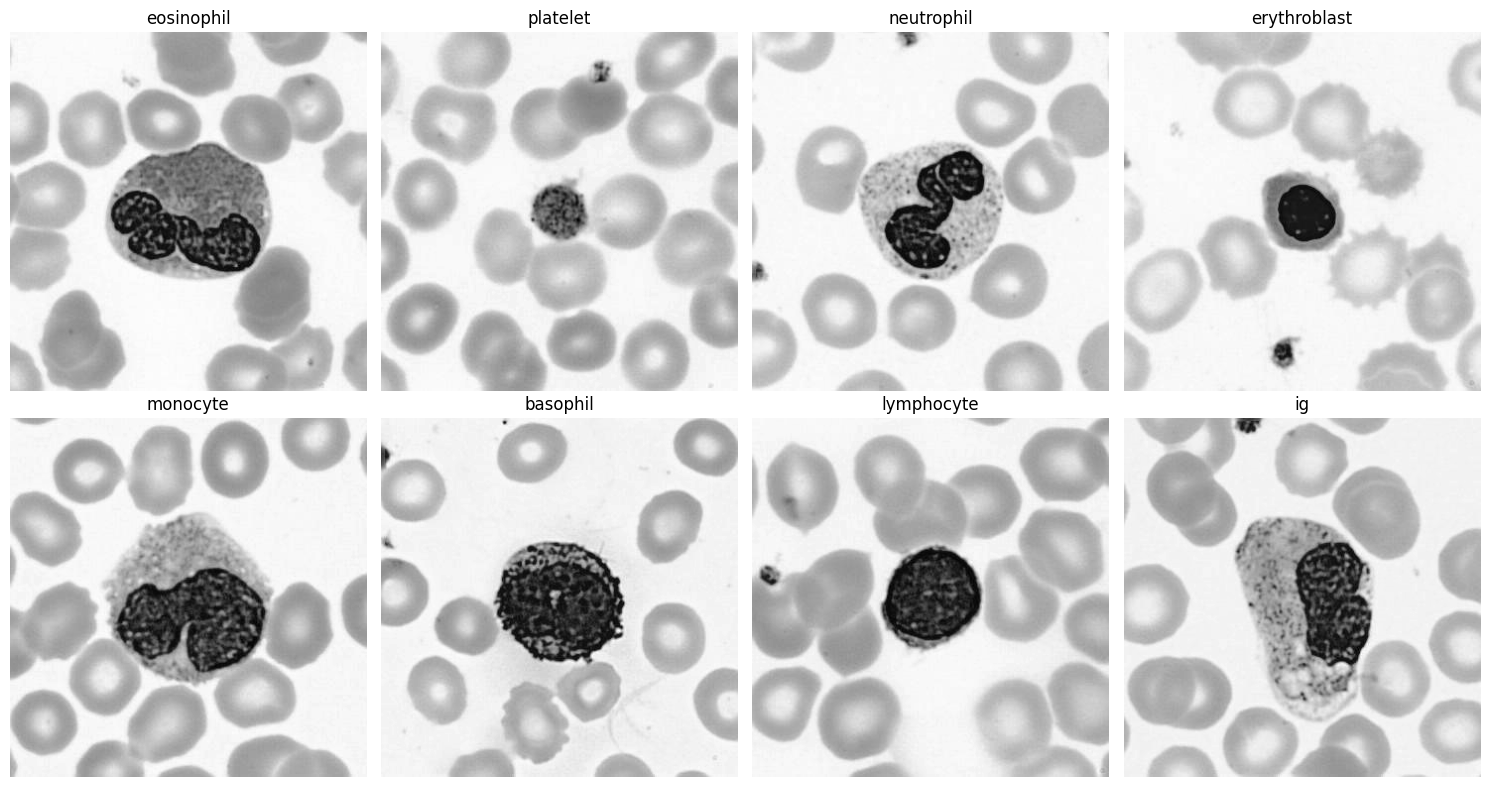

In [ ]:
plot_images_from_folders(folder_image_dict, convert_to_gray=True)

Ensure all images are uniform sized and centered.

In [ ]:
# Define the target shape (height, width)
target_shape = (64, 64)

cell_col_num = []

for i in range(0, 17092):
    # Read and convert the image to grayscale
    image = imread(cell_col[i])
    grayscale_image = rgb2gray(image)
    # Resize the grayscale image to the target shape
    resized_image = resize(grayscale_image, target_shape, anti_aliasing=True)
    # Append the resized image to the list
    cell_col_num.append(resized_image)

# Convert the list to a NumPy array
cell_col_num = np.array(cell_col_num)

print(cell_col_num.shape)

(17092, 64, 64)


In [ ]:
# Save matrix
np.save('cell_col_num.npy', cell_col_num)

# cell_col_num = np.load('cell_col_num.npy')

In [ ]:
cell_col_num = np.array(cell_col_num)
cell_resh = cell_col_num.reshape(cell_col_num.shape[0], cell_col_num.shape[1] * cell_col_num.shape[1])

cell_centered = cell_resh - cell_resh.mean(axis=0)
cell_centered -= cell_centered.mean(axis=1).reshape(cell_col_num.shape[0], -1)

In [ ]:
# Use PCA and cross-validation

cv_scores = []
for i in range(0,16):
    pca = PCA(svd_solver='full', n_components=i)
    print('n_components = %d' % i)
    cv_scores.append(cross_val_score(pca, cell_centered, n_jobs=2).mean())

n_components = 0
n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15


In [ ]:
# Save list
np.save('saved_cv_scores.npy', cv_scores)

In [ ]:
# Load list
cv_scores = np.load('saved_cv_scores.npy')

In [ ]:
pca = PCA(svd_solver='full', n_components=16)
pca.fit(cell_centered)

PCA(n_components=16, svd_solver='full')

In [ ]:
rec_error = pd.DataFrame({
    'n_components': np.arange(0,16),
    'reconst error': cv_scores,
    'explained var ratio': pca.explained_variance_ratio_})

rec_error

n_components  reconst error  explained var ratio
0              0    2703.147651             0.125423
1              1    2895.430441             0.047201
2              2    3037.011769             0.024395
3              3    3096.268822             0.019752
4              4    3146.183701             0.018143
5              5    3189.780882             0.017110
6              6    3279.671912             0.015542
7              7    3328.516853             0.013412
8              8    3364.783219             0.013166
9              9    3399.000684             0.012546
10            10    3431.293116             0.011976
11            11    3461.493295             0.011339
12            12    3490.844398             0.010866
13            13    3519.630990             0.010520
14            14    3547.005404             0.010096
15            15    3574.860248             0.009923

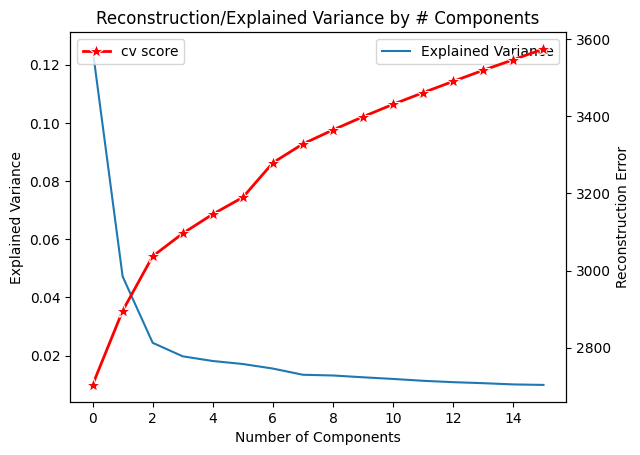

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=rec_error['n_components'], y=rec_error['explained var ratio'],
             ax=ax, label='Explained Variance')

ax2 = ax.twinx()
sns.lineplot(x=rec_error['n_components'], y=rec_error['reconst error'],
             legend=True, marker= '*', markersize=10, color='red', linewidth=2,
             ax=ax2, label='cv score')
plt.title('Reconstruction/Explained Variance by # Components')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance')
ax2.set_ylabel('Reconstruction Error')
plt.show()

# Modeling Methods, Validation, and Performance Metrics

Deep Learning

In [ ]:
## tf.keras.utils.image_dataset_from_directory??

In [ ]:
# Parameters
height = 256
width = 256
batch_size = 32

In [ ]:
# Load Data and Pre-processing using TensorFlow's Keras API
cells_data = tf.keras.utils.image_dataset_from_directory(
    'bloodcells_dataset/bloodcells_dataset',
    image_size=(height, width),
    batch_size=batch_size,
    shuffle=True
)

Found 17092 files belonging to 8 classes.


In [ ]:
class_names = cells_data.class_names
print(class_names)

['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


In [ ]:
# Split Data
dataset_size = len(cells_data)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = cells_data.take(train_size)
remaining = cells_data.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

In [ ]:
# Cross Validation Splits of training set
def k_fold_split(dataset, k=5):
    data_size = len(dataset)
    fold_size = data_size // k
    datasets = []

    for fold in range(k):
        val_data = dataset.skip(fold * fold_size).take(fold_size)
        train_data = dataset.take(fold * fold_size).concatenate(dataset.skip((fold + 1) * fold_size))
        datasets.append((train_data, val_data))

    return datasets

k = 5  # Number of folds
folds = k_fold_split(train_dataset, k)

In [ ]:
# Visualize Accuracy over Epochs
def plot_metrics(model_type, all_histories):
    plt.figure(figsize=(24, 10))

    # Plot all fold accuracies on the left subplot
    plt.subplot(1, 2, 1)
    for i, history in enumerate(all_histories):
        plt.plot(history.history['accuracy'], label=f'Train Acc - Fold {i+1}', linestyle='-')
        plt.plot(history.history['val_accuracy'], label=f'Val Acc - Fold {i+1}', linestyle='--')
    plt.title(f'{model_type} Model Accuracy Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot all fold losses on the right subplot
    plt.subplot(1, 2, 2)
    for i, history in enumerate(all_histories):
        plt.plot(history.history['loss'], label=f'Train Loss - Fold {i+1}', linestyle='-')
        plt.plot(history.history['val_loss'], label=f'Val Loss - Fold {i+1}', linestyle='--')
    plt.title(f'{model_type} Model Loss Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Models

## Logistic Regression Baseline Model

Logistic Regression model compiled with the SGD (Stochastic Gradient Descent) optimizer.

In [ ]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Simple logistic regression model for multiclass classification
def create_logistic_regression_model(input_shape, num_classes):
    lr_model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=input_shape),
        tf.keras.layers.Flatten(input_shape=input_shape),  # Flatten the input
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Single dense layer with softmax activation
    ])
    return lr_model

input_shape = (256, 256, 3)
num_classes = 8

# Store objects
val_accuracies = []
all_histories = []
k = len(folds)

# Build and compile model for each fold
for fold_index, (train_data, val_data) in enumerate(folds):
    lr_model = create_logistic_regression_model(input_shape, num_classes)
    lr_model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),  # SGD optimizer
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"Training fold {fold_index + 1}/{k}")
    history = lr_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10
    )

    # Store the history in all_histories
    all_histories.append(history)

    # Evaluate model on the validation set
    val_loss, val_accuracy = lr_model.evaluate(val_data)
    val_accuracies.append(val_accuracy)
    print(f"Fold {fold_index + 1} - Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Training fold 1/5
Epoch 1/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 80s 186ms/step - accuracy: 0.1705 - loss: 450.2312 - val_accuracy: 0.3172 - val_loss: 342.1199
Epoch 2/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 77s 175ms/step - accuracy: 0.3145 - loss: 239.8489 - val_accuracy: 0.5967 - val_loss: 92.6067
Epoch 3/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 82s 192ms/step - accuracy: 0.3763 - loss: 171.0808 - val_accuracy: 0.5354 - val_loss: 126.2408
Epoch 4/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 85s 198ms/step - accuracy: 0.4128 - loss: 151.0767 - val_accuracy: 0.4587 - val_loss: 103.8854
Epoch 5/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 80s 188ms/step - accuracy: 0.4280 - loss: 132.2662 - val_accuracy: 0.4422 - val_loss: 158.7640
Epoch 6/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 79s 184ms/step - accuracy: 0.4561 - loss: 119.4969 - val_accuracy: 0.3626 - val_loss: 158.0304
Epoch 7/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 78s 183ms/step - accuracy: 0.4640 - loss: 107.1427 - val_accuracy: 0.4587 - val_loss: 93.4818
Epoch 8/10
428/428 ━━━━━━━━━━━━━━━━━━━━

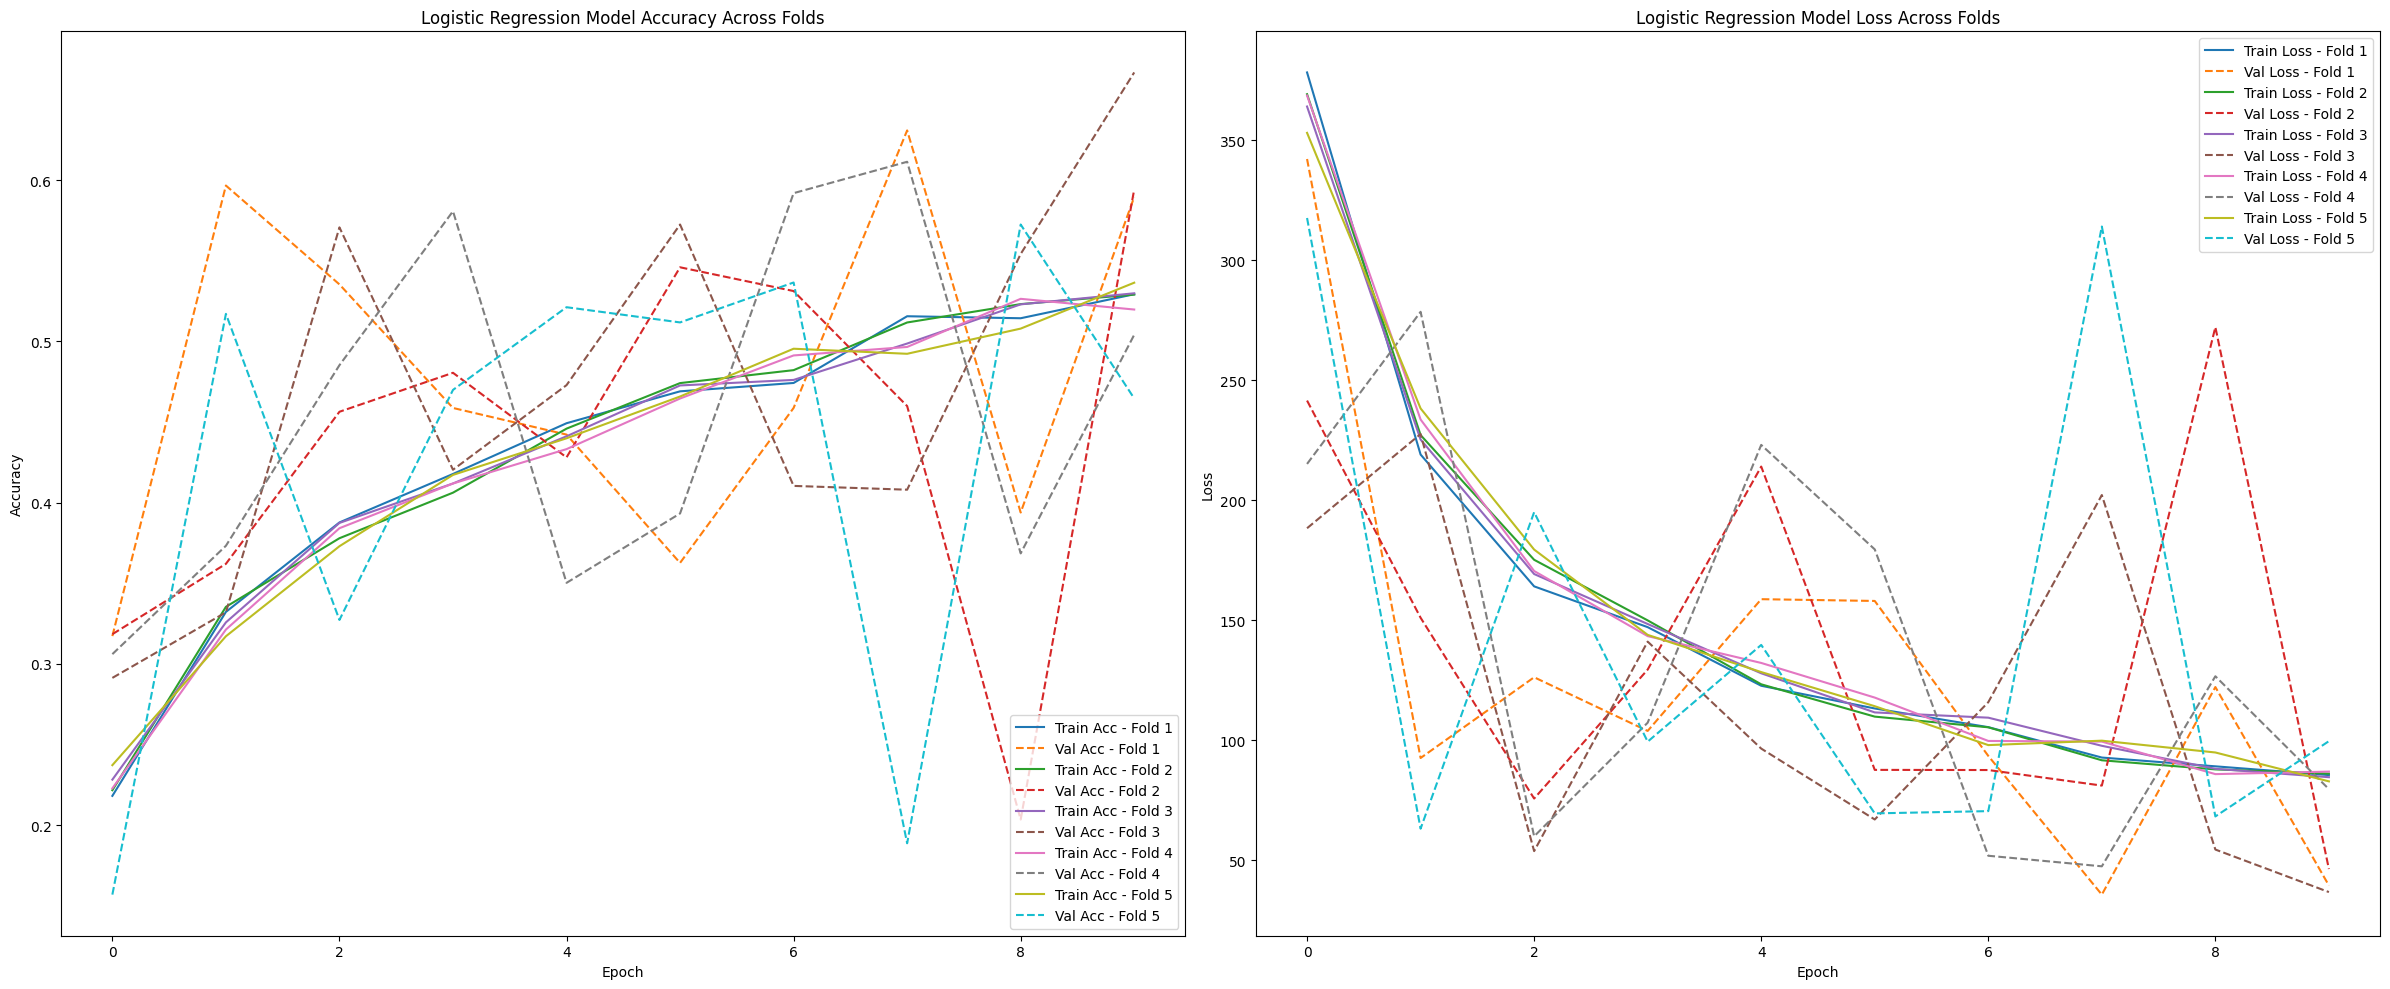

In [ ]:
# plot metrics for all folds
plot_metrics("Logistic Regression", all_histories)

In [ ]:
# Average validation accuracy
lr_average_val_accuracy = sum(val_accuracies) / k
print(f"Average Validation Accuracy: {lr_average_val_accuracy}")

# Evaluate the model on the test set using the last trained model (or you can retrain on the whole training set)
lr_test_loss, lr_test_accuracy = lr_model.evaluate(test_dataset)
print(f"Test Loss: {lr_test_loss}, Test Accuracy: {lr_test_accuracy}")

Average Validation Accuracy: 0.5577941179275513
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.4544 - loss: 104.5353
Test Loss: 107.13314056396484, Test Accuracy: 0.44470587372779846


In [ ]:
# Average validation accuracy
lr_average_val_accuracy = sum(val_accuracies) / k
print(f"Average Validation Accuracy: {lr_average_val_accuracy}")

# Evaluate the model on the test set using the last trained model (or you can retrain on the whole training set)
lr_test_loss, lr_test_accuracy = lr_model.evaluate(test_dataset)
print(f"Test Loss: {lr_test_loss}, Test Accuracy: {lr_test_accuracy}")

Average Validation Accuracy: 0.5577941179275513
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.4625 - loss: 98.3611
Test Loss: 103.8840103149414, Test Accuracy: 0.45235294103622437


In [ ]:
lr_model.save(os.path.join('LogReg_SGD.keras'))

## Convolutional Neural Network with cross validation k =  5

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Define the CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Add dropout to reduce overfitting
        layers.Dense(len(cells_data.class_names), activation='softmax')
    ])

    # Compile the model with a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize lists to store validation accuracies and losses for each fold
val_acc = []
val_loss = []

# Cross Validation Splits of the dataset
def k_fold_split(dataset, k=5):
    data_size = len(dataset)
    fold_size = data_size // k
    datasets = []

    for fold in range(k):
        val_data = dataset.skip(fold * fold_size).take(fold_size)
        train_data = dataset.take(fold * fold_size).concatenate(dataset.skip((fold + 1) * fold_size))
        datasets.append((train_data, val_data))

    return datasets


# Apply k-fold cross-validation
folds = k_fold_split(cells_data, k)

# Initialize list to store histories
cnn_histories = []

for i, (train_dataset, val_dataset) in enumerate(folds):
    print(f"Training fold {i+1}/{k}...")

    # Apply data augmentation to the training dataset
    augmented_train_ds = train_dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y))

    # Create a new instance of the model for each fold
    model = create_model()

    # Train the model
    history = model.fit(augmented_train_ds, validation_data=val_dataset, epochs=5)

    # Store the history and accuracies for plotting
    cnn_histories.append(history)

    # Evaluate the model on the validation dataset
    val_loss_value, val_accuracy_value = model.evaluate(val_dataset)

    # Store validation loss and accuracy
    val_loss.append(val_loss_value)
    val_acc.append(val_accuracy_value)

Training fold 1/5...
Epoch 1/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 228s 500ms/step - accuracy: 0.6614 - loss: 1.5591 - val_accuracy: 0.7982 - val_loss: 0.6089
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 208s 483ms/step - accuracy: 0.8655 - loss: 0.4060 - val_accuracy: 0.8695 - val_loss: 0.4048
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 204s 474ms/step - accuracy: 0.8890 - loss: 0.3307 - val_accuracy: 0.8438 - val_loss: 0.4747
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 208s 484ms/step - accuracy: 0.9086 - loss: 0.2770 - val_accuracy: 0.8300 - val_loss: 0.6031
Epoch 5/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 203s 472ms/step - accuracy: 0.9204 - loss: 0.2390 - val_accuracy: 0.8105 - val_loss: 0.7114
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8040 - loss: 0.7624
Training fold 2/5...
Epoch 1/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 215s 489ms/step - accuracy: 0.6787 - loss: 1.4254 - val_accuracy: 0.6574 - val_loss: 1.0901
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 207s 483ms/step - accuracy: 0.8653 - loss: 0.4071 - val_a

In [ ]:
model.save(os.path.join('cv_CNN.keras'))

In [ ]:
# Calculate and print the average validation accuracy and loss
average_val_accuracy = sum(val_acc) / len(val_acc)
average_val_loss = sum(val_loss) / len(val_loss)

print(f"Average Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Average Validation Loss: {average_val_loss:.4f}")

Average Validation Accuracy: 0.8347
Average Validation Loss: 0.6055


In [ ]:
cnn_test_loss, cnn_test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {cnn_test_loss:.4f}, Test Accuracy: {cnn_test_accuracy:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5810 - loss: 1.3621
Test Loss: 1.3225, Test Accuracy: 0.5704


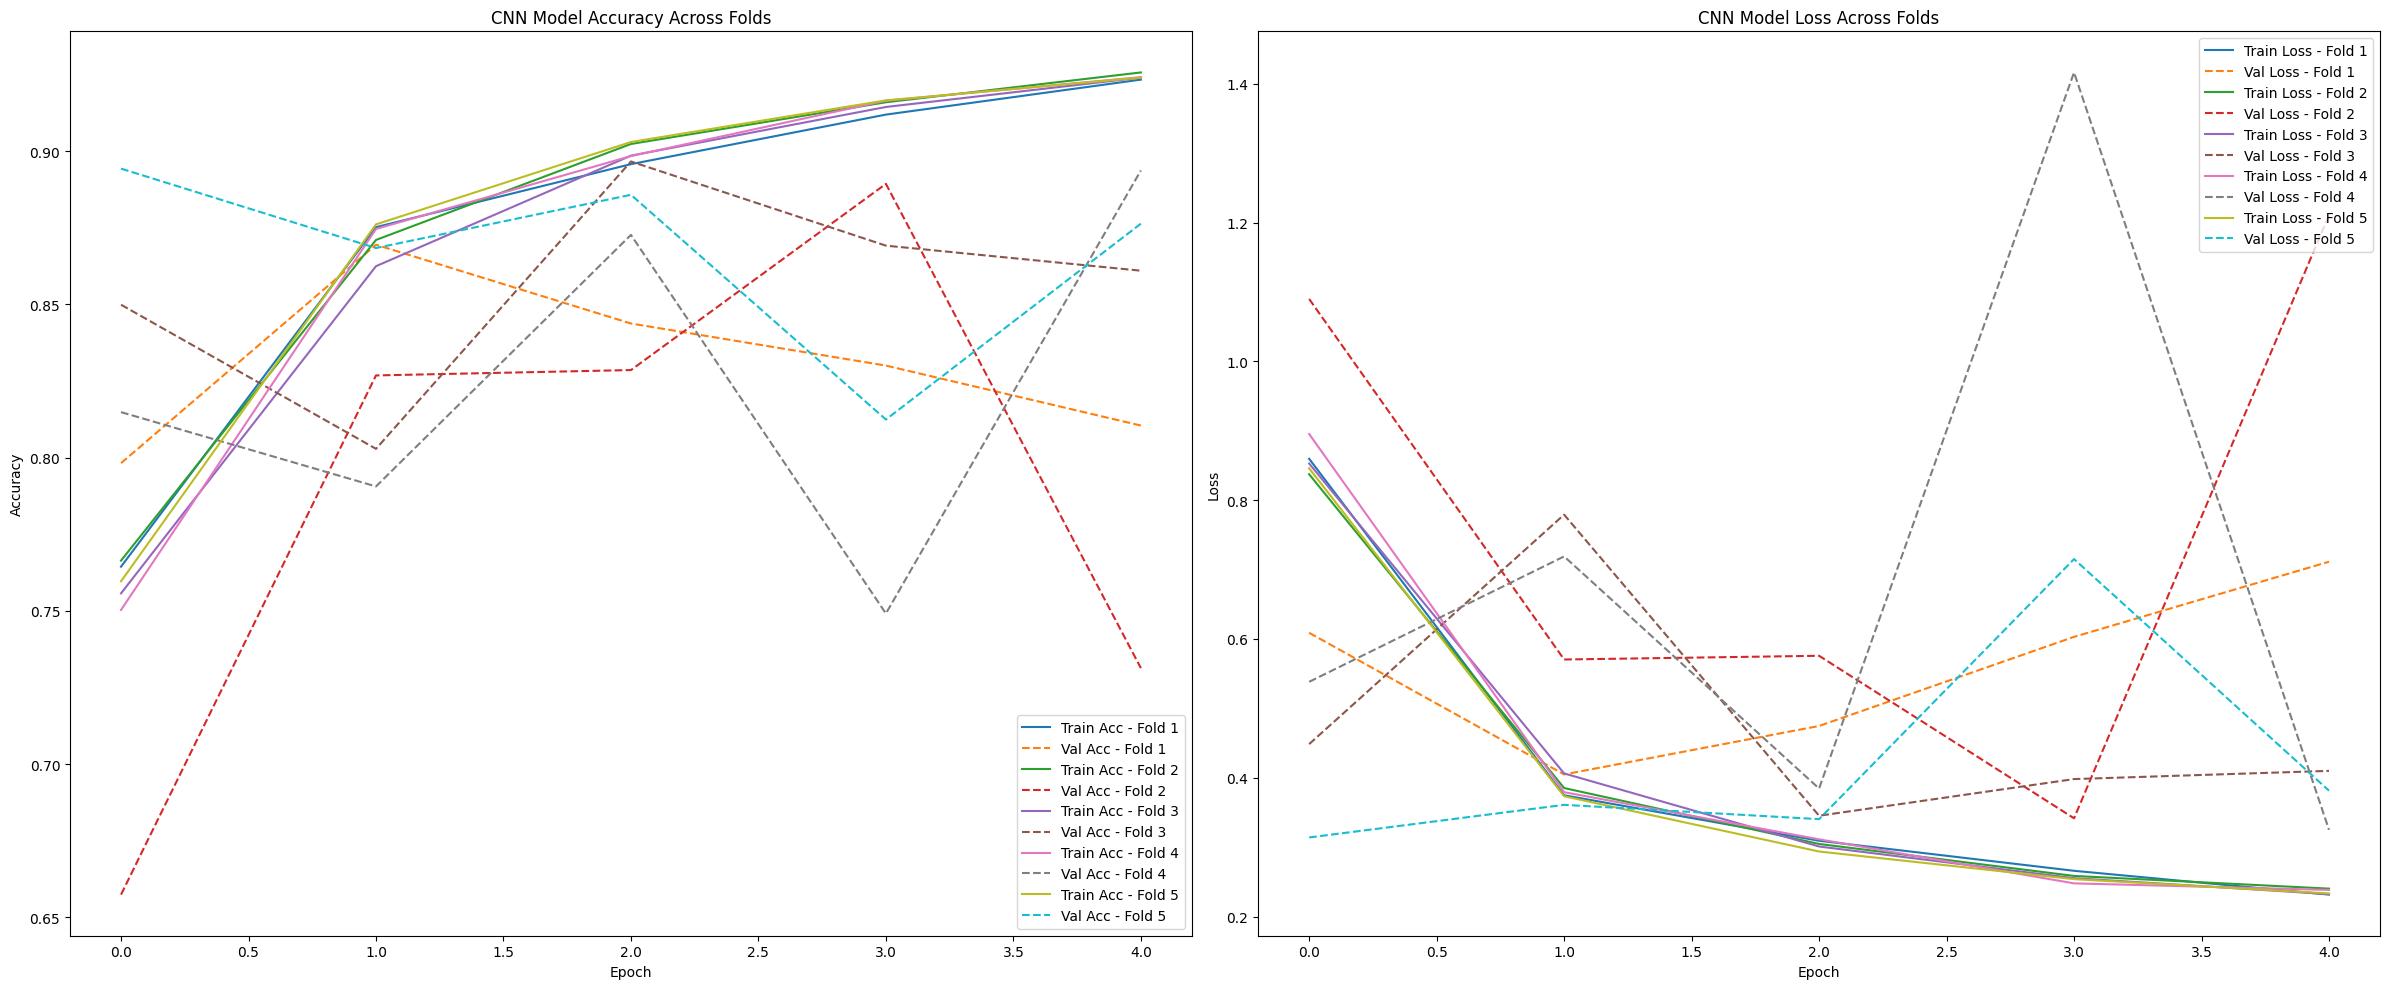

In [ ]:
plot_metrics("CNN", cnn_histories)

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,253,274 (298.51 MB)

 Trainable params: 26,084,104 (99.50 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 52,168,210 (199.01 MB)

## Multi-layer perceptron

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

height = 256
width = 256
batch_size = 64

cells_data = tf.keras.utils.image_dataset_from_directory(
    'bloodcells_dataset/bloodcells_dataset',
    image_size=(height, width),
    batch_size=batch_size,
    shuffle=True
)

class_names = cells_data.class_names
num_classes = len(class_names)


dataset_size = len(cells_data)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

train_dataset = cells_data.take(train_size)
remaining = cells_data.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)


train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

def create_mlp_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=input_shape),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


input_shape = (height, width, 3)

model = create_mlp_model(input_shape, num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    jit_compile=True
)

val_acc = []
val_loss = []

# Cross Validation Splits of the dataset
def k_fold_split(dataset, k=5):
    data_size = len(dataset)
    fold_size = data_size // k
    datasets = []

    for fold in range(k):
        val_data = dataset.skip(fold * fold_size).take(fold_size)
        train_data = dataset.take(fold * fold_size).concatenate(dataset.skip((fold + 1) * fold_size))
        datasets.append((train_data, val_data))

    return datasets


# Apply k-fold cross-validation
folds = k_fold_split(cells_data, k)

mlp_histories = []

for i, (train_dataset, val_dataset) in enumerate(folds):
    print(f"Training MLP for fold {i + 1}...")


    model = create_mlp_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=5
    )

    mlp_histories.append(history)

    # Evaluate the model on the validation set
    val_loss_value, val_accuracy = model.evaluate(val_dataset)
    val_loss.append(val_loss_value)
    val_acc.append(val_accuracy)
    print(f"Fold {i + 1} - Validation Loss: {val_loss_value:.4f}, Validation Accuracy: {val_accuracy:.4f}")

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


print(f"Average Validation Loss: {sum(val_loss) / len(val_loss):.4f}")
print(f"Average Validation Accuracy: {sum(val_acc) / len(val_acc):.4f}")

Found 17092 files belonging to 8 classes.
Training MLP for fold 1...
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2301 - loss: 44.7117 - val_accuracy: 0.4372 - val_loss: 2.6913
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4485 - loss: 2.5843 - val_accuracy: 0.5973 - val_loss: 1.5871
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4865 - loss: 2.2549 - val_accuracy: 0.5687 - val_loss: 1.8510
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5906 - loss: 1.3647 - val_accuracy: 0.2450 - val_loss: 4.5430
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5578 - loss: 1.5550 - val_accuracy: 0.4761 - val_loss: 1.8861
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4668 - loss: 1.9406
Fold 1 - Validation Loss: 1.8852, Validation Accuracy: 0.4758
Training MLP for fold 2...
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.2197 - loss: 47.7087 - val_accuracy: 0.3199 - val_loss: 6.10

In [ ]:
mlp_test_loss, mlp_test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {mlp_test_loss:.4f}, Test Accuracy: {mlp_test_accuracy:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5943 - loss: 1.6013
Test Loss: 1.6256, Test Accuracy: 0.5739


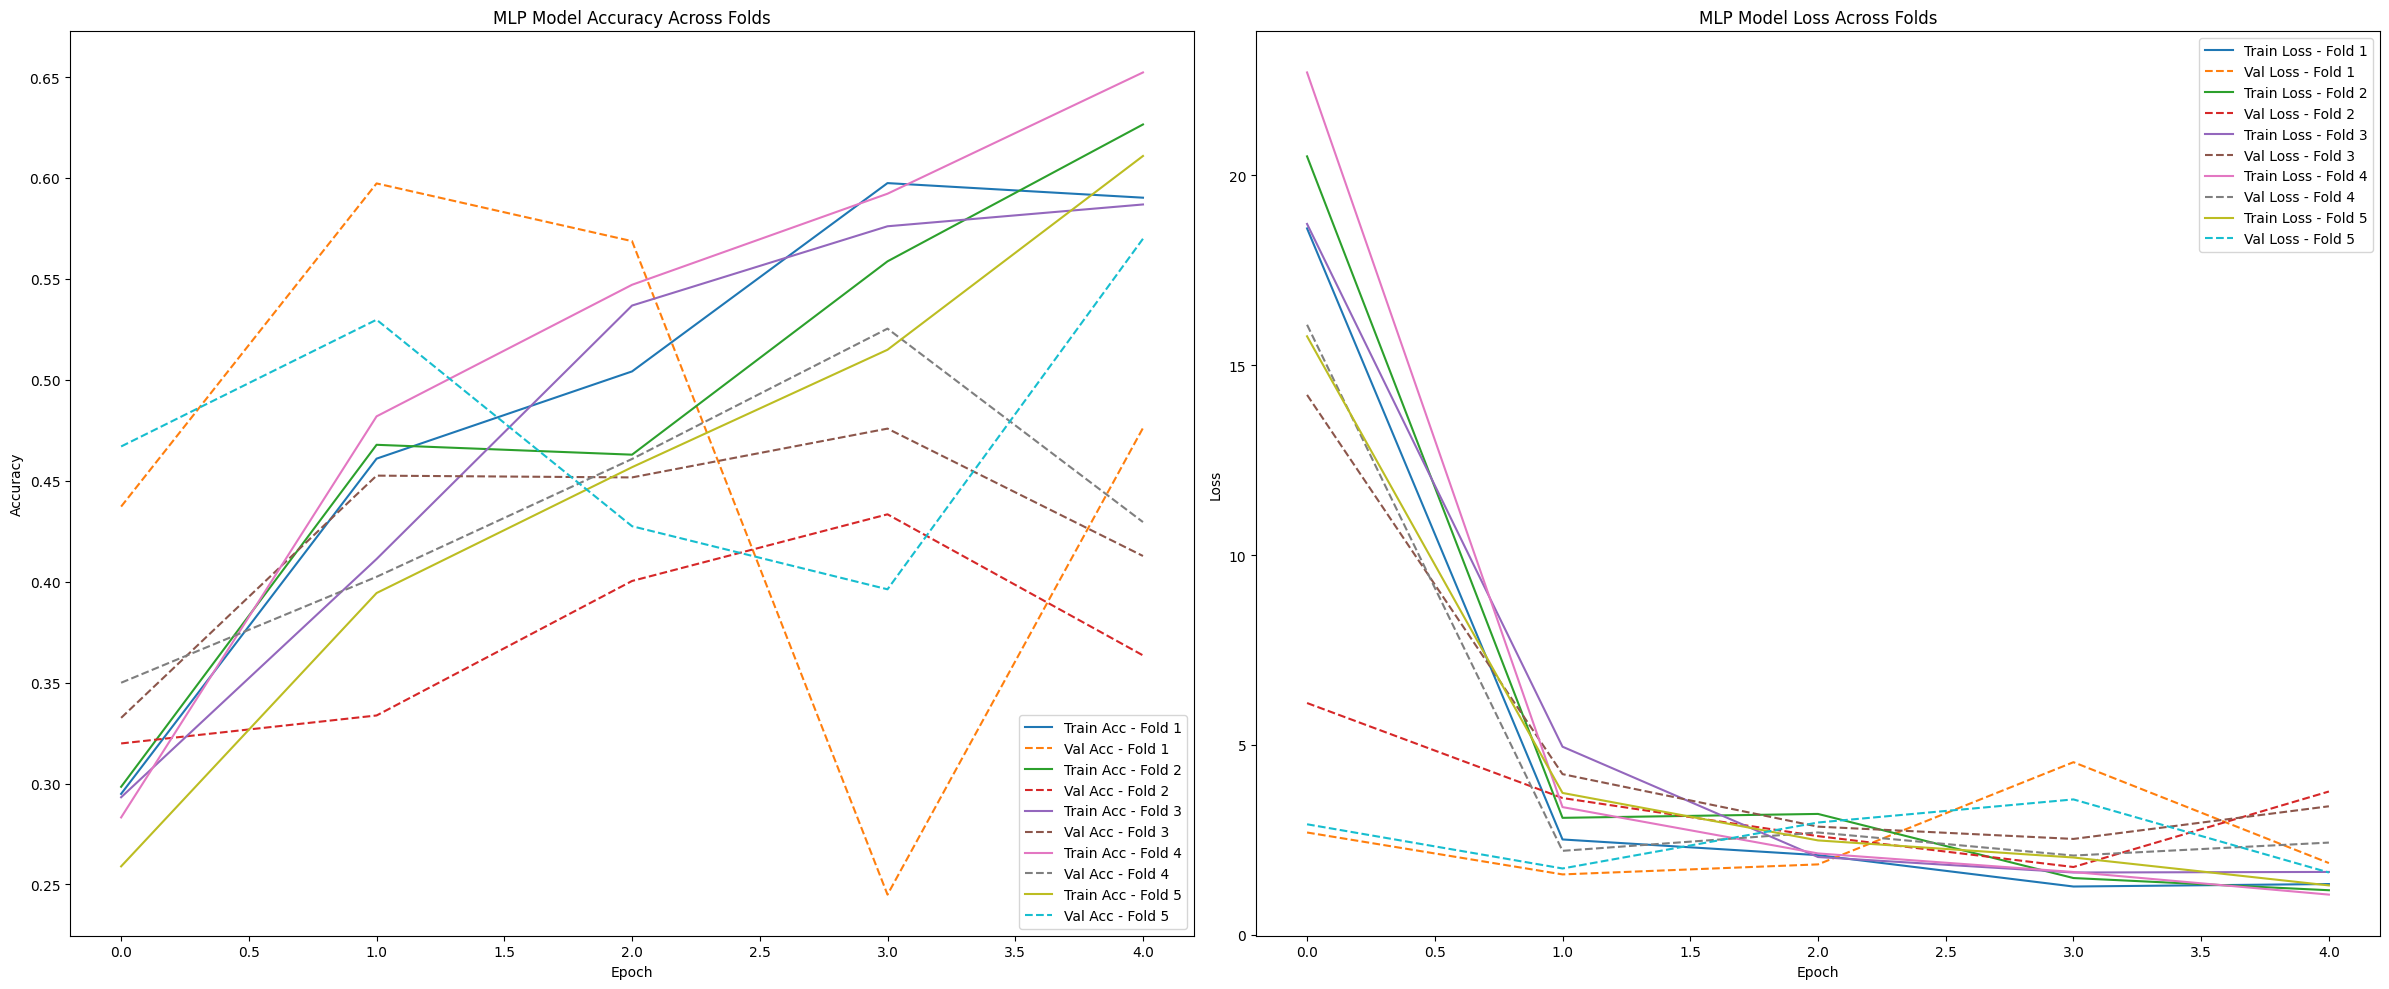

In [ ]:
plot_metrics("MLP", mlp_histories)

In [ ]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_19 (Rescaling)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 196608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 128)                 │      25,165,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,524,186 (288.10 MB)

 Trainable params: 25,174,728 (96.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,349,458 (192.07 MB)